# 1. 강의영상

{{<video https://youtu.be/playlist?list=PLQqh36zP38-z8ceMijNQrcczhH3ocuP1Y&si=UehL2BELwmid586_ >}}

# 2. imports

In [5]:
# !conda install scikit-learn -y

In [116]:
import numpy as np 
import pandas as pd 
import sklearn.impute
import sklearn.linear_model
import missingno as msno

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# 3. 자료불러오기

`-` 아래의 코드는 `kaggle.json` 파일이 셋팅된 codespace 혹은 `kaggle.json` 파일이 셋팅된 리눅스 컴퓨터가 있는 경우만 사용가능 (이런거 셋팅하는 방법은 대면수업에서 해요)

In [224]:
!kaggle competitions download -c titanic
!unzip titanic.zip -d ./titanic
df_train = pd.read_csv('titanic/train.csv')
df_test = pd.read_csv('titanic/test.csv')
!rm titanic.zip
!rm -rf titanic/

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 6.10MB/s]
Archive:  titanic.zip
  inflating: ./titanic/gender_submission.csv  
  inflating: ./titanic/test.csv      
  inflating: ./titanic/train.csv     


`-` 리눅스서버를 사용할 수 없는 경우 download 후 압축풀어서 사용

In [171]:
df_train = df_train.assign(Fsize = df_train.SibSp + df_train.Parch).drop(['SibSp', 'Parch'], axis=1)

# 4. 결측치 확인 및 처리

## A. 결측치 체크 

`-` 결측치확인 

In [172]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   Ticket       891 non-null    object 
 7   Fare         891 non-null    float64
 8   Cabin        204 non-null    object 
 9   Embarked     889 non-null    object 
 10  Fsize        891 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


## B. 시각화 

<AxesSubplot: >

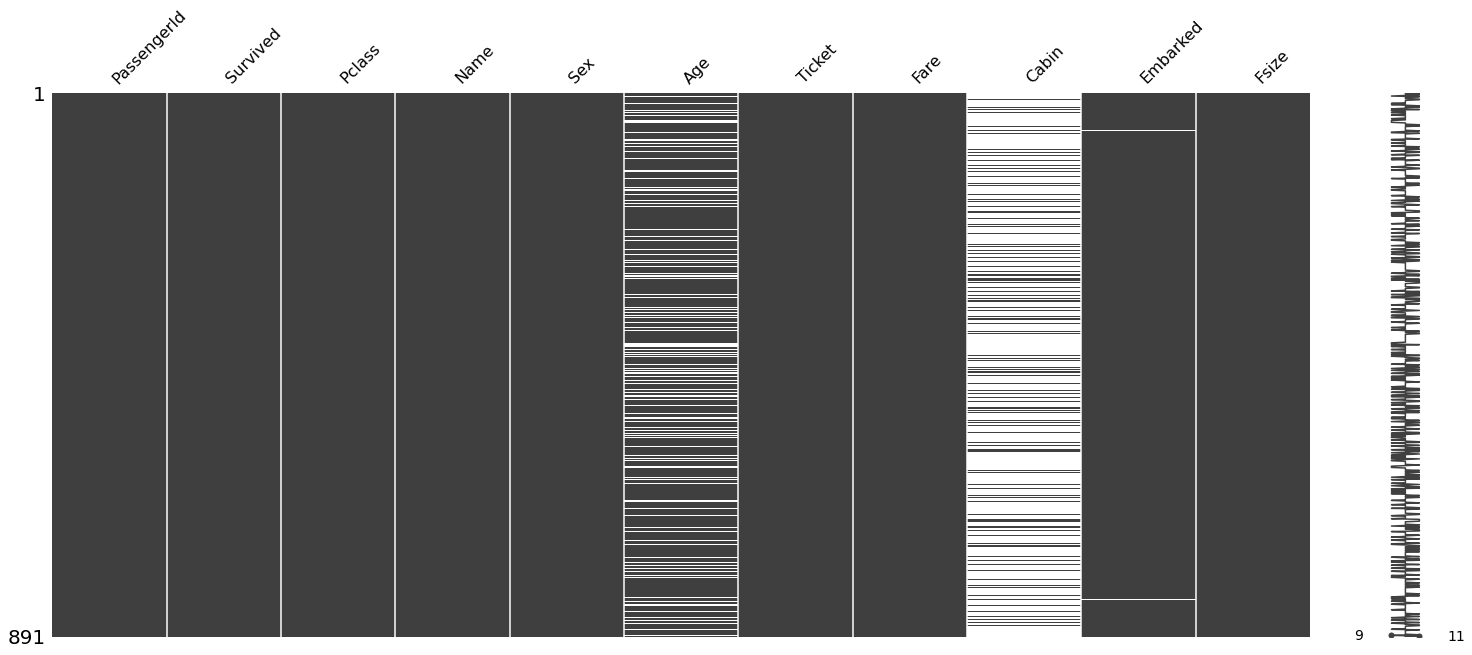

In [173]:
msno.matrix(df_train) 
# msno.bar(df_train) # 큰 의미 X 
# msno.dendrogram(df_train) # 큰 의미 X 
# msno.heatmap(df_train) # 큰 의미 X 

## C. 결측치 처리

In [174]:
df_train.select_dtypes(include="number")

,PassengerId,Survived,Pclass,Age,Fare,Fsize
0,1,0,3,22.0,7.2500,1
1,2,1,1,38.0,71.2833,1
2,3,1,3,26.0,7.9250,0
3,4,1,1,35.0,53.1000,1
4,5,0,3,35.0,8.0500,0
...,...,...,...,...,...,...
886,887,0,2,27.0,13.0000,0
887,888,1,1,19.0,30.0000,0
888,889,0,3,NaN,23.4500,3
889,890,1,1,26.0,30.0000,0


In [175]:
df_train.select_dtypes(include="object")

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S
...,...,...,...,...,...
886,"Montvila, Rev. Juozas",male,211536,NaN,S
887,"Graham, Miss. Margaret Edith",female,112053,B42,S
888,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,NaN,S
889,"Behr, Mr. Karl Howell",male,111369,C148,C


In [176]:
def impute_missing(df):
    df_imputed = df.copy()
    df_num = df.select_dtypes(include="number")
    df_cat = df.select_dtypes(exclude="number")
    df_imputed[df_num.columns] = sklearn.impute.SimpleImputer().fit_transform(df_num) # mean impute
    df_imputed[df_cat.columns] = sklearn.impute.SimpleImputer(strategy='most_frequent').fit_transform(df_cat) 
    return df_imputed

<AxesSubplot: >

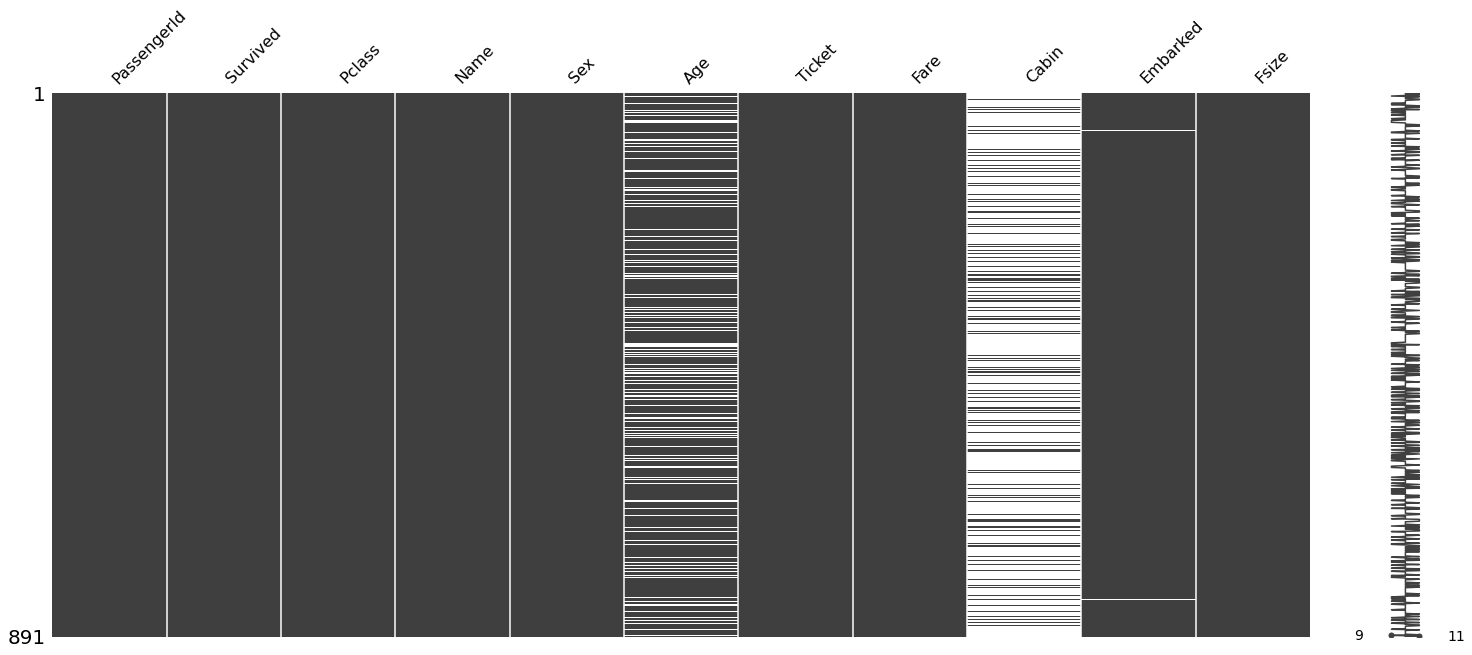

In [177]:
msno.matrix(df_train)

<AxesSubplot: >

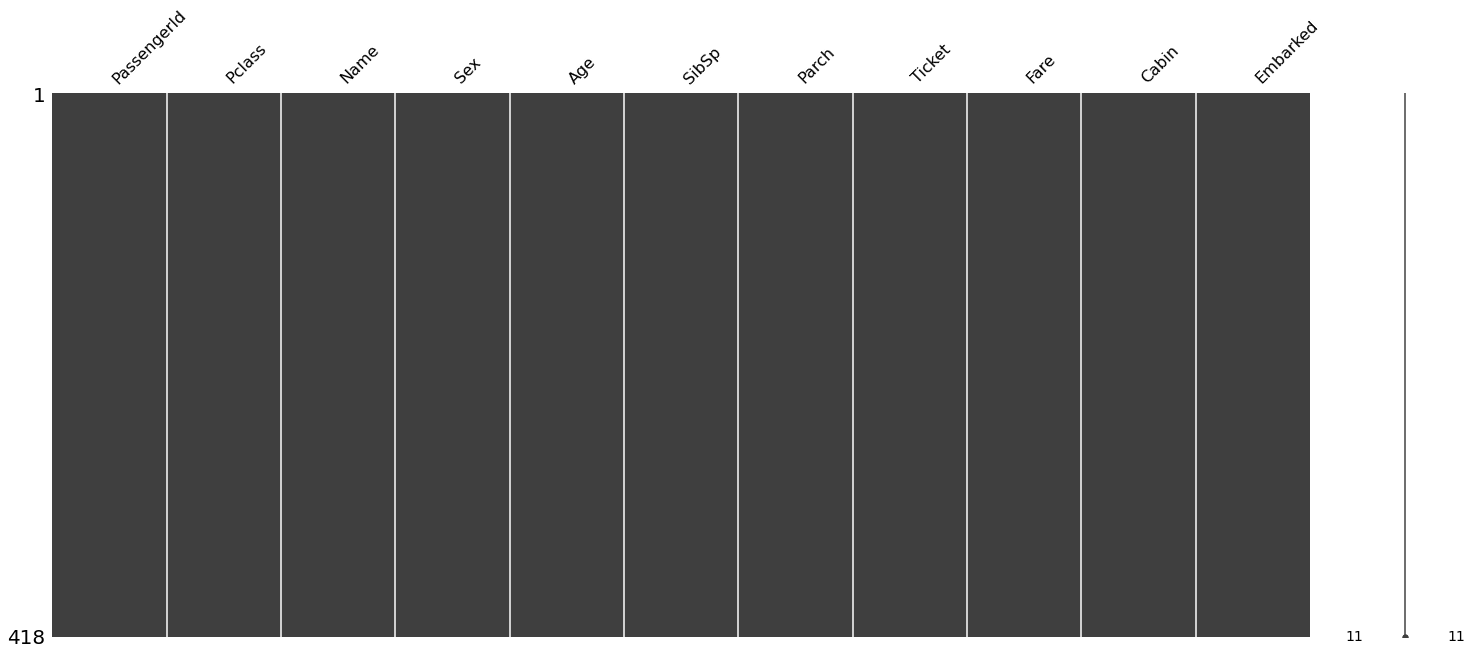

In [178]:
msno.matrix(impute_missing(df_test))

<AxesSubplot: >

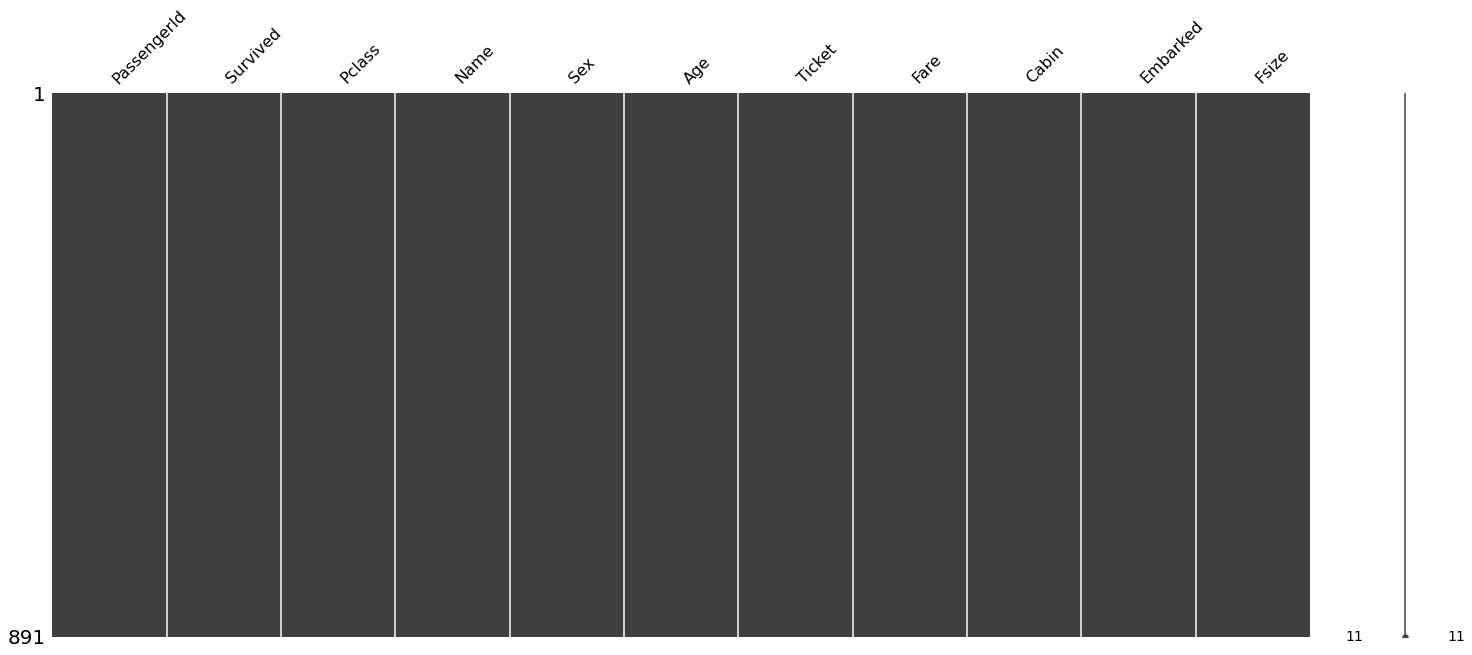

In [179]:
msno.matrix(impute_missing(df_train))

# 5. 분석

In [180]:
set(df_train.columns) - set(df_test.columns)

{'Fsize', 'Survived'}

## A. 자료의 정리 

In [181]:
{c:len(set(df_train[c])) for c in df_train.select_dtypes(include="object").columns}

{'Name': 891, 'Sex': 2, 'Ticket': 681, 'Cabin': 148, 'Embarked': 4}

- `Sex`, `Embarked` 정도가 유의미한 변수로 보임.

In [182]:
X = pd.get_dummies(impute_missing(df_train).drop(['PassengerId','Survived','Name','Ticket','Cabin'],axis=1))
y = impute_missing(df_train)[['Survived']]

In [183]:
X

,Pclass,Age,Fare,Fsize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3.0,22.000000,7.2500,1.0,0,1,0,0,1
1,1.0,38.000000,71.2833,1.0,1,0,1,0,0
2,3.0,26.000000,7.9250,0.0,1,0,0,0,1
3,1.0,35.000000,53.1000,1.0,1,0,0,0,1
4,3.0,35.000000,8.0500,0.0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
886,2.0,27.000000,13.0000,0.0,0,1,0,0,1
887,1.0,19.000000,30.0000,0.0,1,0,0,0,1
888,3.0,29.699118,23.4500,3.0,1,0,0,0,1
889,1.0,26.000000,30.0000,0.0,0,1,1,0,0


## B. predictor 생성 

In [184]:
predictr = sklearn.linear_model.LogisticRegression()
predictr

LogisticRegression()

## C. 학습

In [185]:
predictr.fit(X, y)

/home/jy/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jy/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## D. 예측 

In [186]:
predictr.predict(X)

array([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0.

## E. 평가 

In [190]:
predictr.score(X,y)

0.8002244668911336

# 6. HW

위와 동일한 방식으로 `test.csv`에서의 생존여부를 예측하고 kaggle에 제출 

In [194]:
df_test = df_test.assign(Fsize = df_test.SibSp + df_test.Parch).drop(['SibSp','Parch'],axis=1)

In [196]:
df_test.shape

(418, 10)

`-` ***결측치 체크***

In [197]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
Ticket           0
Fare             1
Cabin          327
Embarked         0
Fsize            0
dtype: int64

- Age, Fare, Cabin에 결측치가 존재한다.

`-` 결측치 시각화

In [198]:
import missingno as msno

<AxesSubplot: >

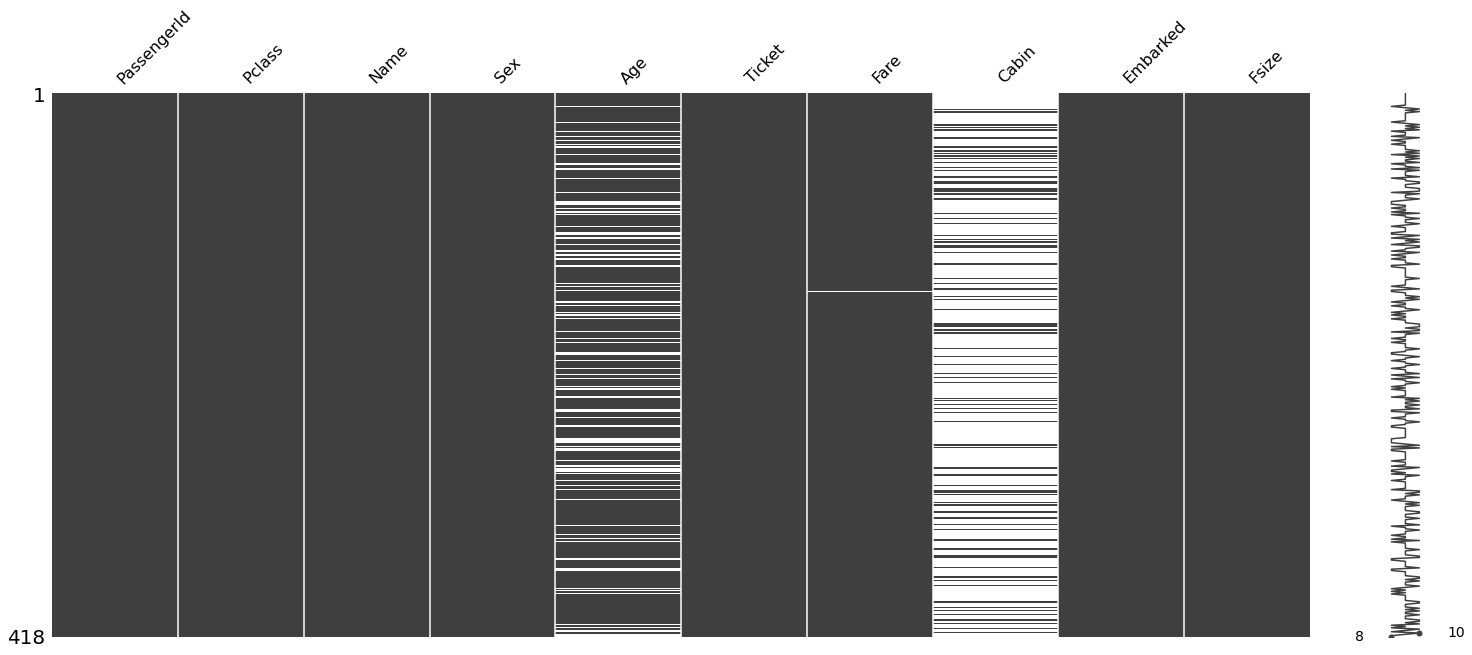

In [199]:
# 결측치 패턴 확인
msno.matrix(df_test)

`-` ***결측치 처리***

In [195]:
def impute_missing(df):
    df_imputed = df.copy()
    df_num = df.select_dtypes(include="number")
    df_cat = df.select_dtypes(exclude="number")
    df_imputed[df_num.columns] = sklearn.impute.SimpleImputer().fit_transform(df_num) # mean impute
    df_imputed[df_cat.columns] = sklearn.impute.SimpleImputer(strategy='most_frequent').fit_transform(df_cat) 
    return df_imputed

In [200]:
# df_imputed_test = df_test.copy()

# df_num_test = df_test.select_dtypes(include='number')
# df_cat_test = df_test.select_dtypes(exclude='number')

# imputr_num = sklearn.impute.SimpleImputer()
# imputr_cat = sklearn.impute.SimpleImputer(strategy="most_frequent")

# df_imputed_test[df_num_test.columns] = imputr_num.fit_transform(df_num_test)
# df_imputed_test[df_cat_test.columns] = imputr_cat.fit_transform(df_cat_test)

In [213]:
df_imputed_test = impute_missing(df_test)

<AxesSubplot: >

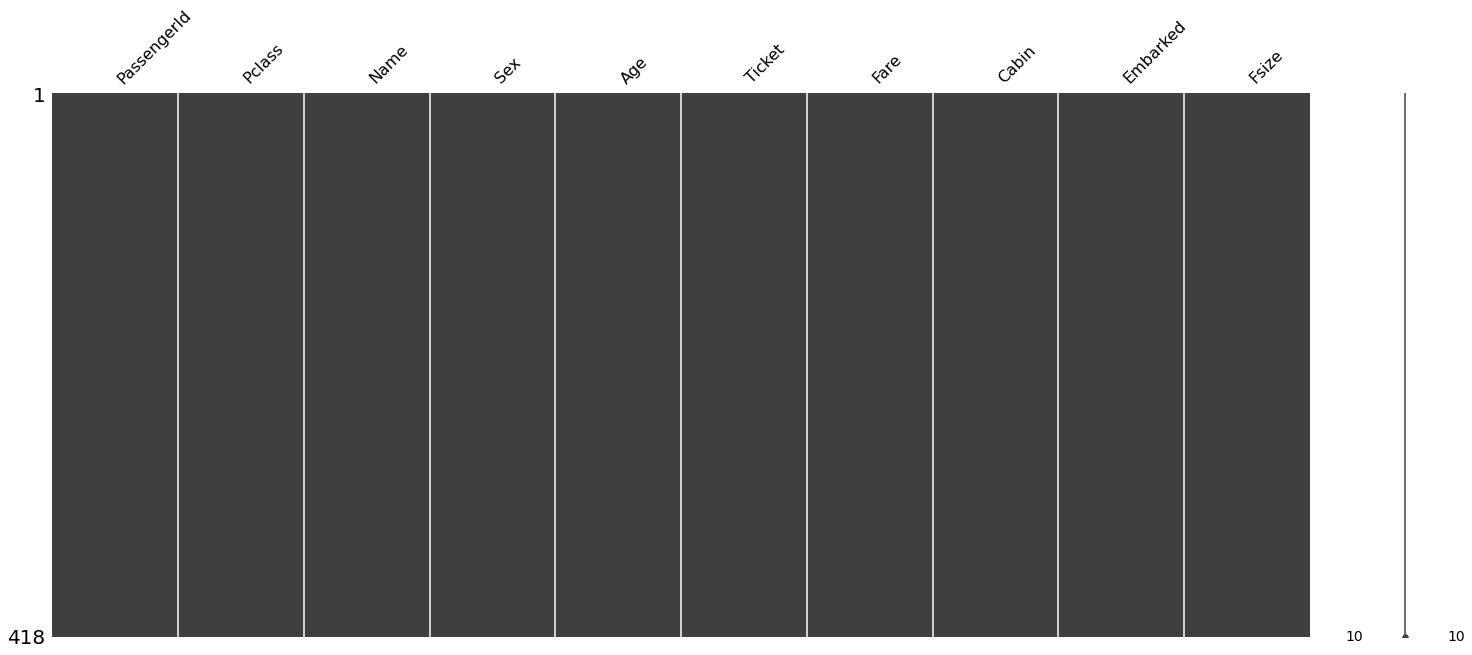

In [214]:
# 결측값 처리 완료!
msno.matrix(df_imputed_test)

- test set에 있는 결측값을 모두 처리하였다.

`-` ***분석***

In [215]:
{c:len(set(df_train[c])) for c in df_train.select_dtypes(include='object')}

{'Name': 891, 'Sex': 2, 'Ticket': 681, 'Cabin': 148, 'Embarked': 4}

- Name, Ticket, Cabin 를 제거하자.

In [216]:
X_test = pd.get_dummies(df_imputed_test.drop(['PassengerId','Name','Ticket','Cabin'], axis=1))

In [217]:
X_test

,Pclass,Age,Fare,Fsize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3.0,34.50000,7.8292,0.0,0,1,0,1,0
1,3.0,47.00000,7.0000,1.0,1,0,0,0,1
2,2.0,62.00000,9.6875,0.0,0,1,0,1,0
3,3.0,27.00000,8.6625,0.0,0,1,0,0,1
4,3.0,22.00000,12.2875,2.0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
413,3.0,30.27259,8.0500,0.0,0,1,0,0,1
414,1.0,39.00000,108.9000,0.0,1,0,1,0,0
415,3.0,38.50000,7.2500,0.0,0,1,0,0,1
416,3.0,30.27259,8.0500,0.0,0,1,0,0,1


In [218]:
pred_y = predictr.predict(X_test).astype('int64')

In [219]:
pred_y

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [211]:
sub = pd.read_csv('./titanic/gender_submission.csv')

In [212]:
# sub.assign(Survived = pred_y).to_csv('./submission/20230927_hw4.csv', index=False)
# sub.assign(Survived = pred_y).to_csv('./submission/20230927_hw4_dropId.csv', index=False)
# sub.assign(Survived = pred_y).to_csv('./submission/20230927_hw4_Fsize.csv', index=False)